In [261]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

font = {'family':'serif', 'weight':'normal', 'size':16}
fontTitle = {'family':'serif', 'weight':'normal', 'size':20}

# Costas Loop QAM

A princípio é considerado o modelo de um receptor, com estimador costas loop, abaixo

!['Modelo Costas Loop QAM'](Media/CostasQAM.png "Modelo Costas Loop QAM")

Considerando o sinal $r(t)$ entrando no receptor:
$$r(t) ~=~ v_I(t) \sqrt{2}~cos(2\pi F_C t + \theta) ~+~ v_Q(t) \sqrt{2}~sin(2\pi F_C t + \theta)$$

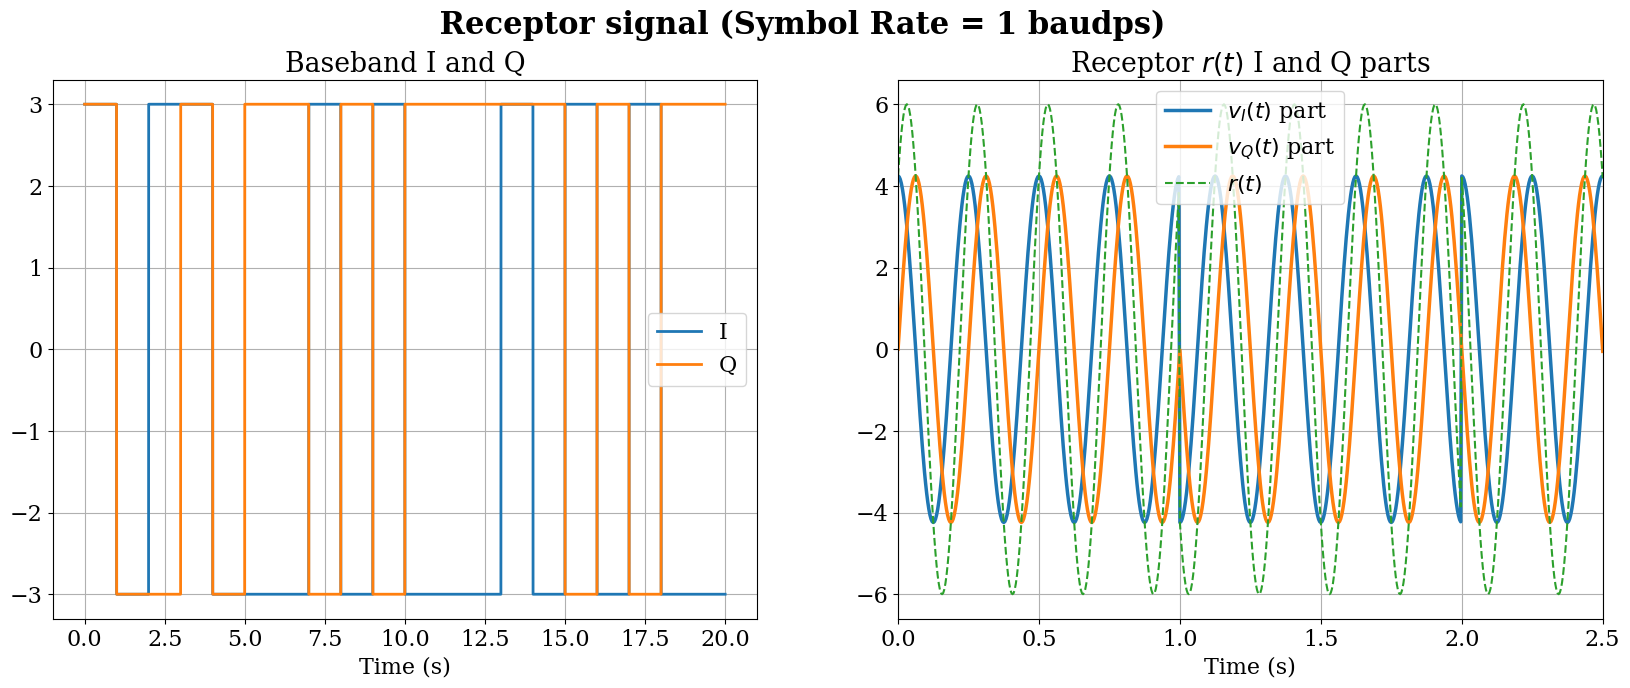

In [262]:
PtsNum = 20 # Number of points
M = 256 # Upsample by M
ConstI = [3,-3] # I Constellation
ConstQ = [3,-3] # Q Constellation

theta = 0    # Carrier phase (rad)
Fc = 4      # Carrier frequency (Hz)
SymbRate = 1 # Symbol Transmission Rate (symb/s)

window = np.ones(M) # Janela retangular

sig = np.zeros(PtsNum*M)
sig[::M] = np.random.choice(ConstI,int(PtsNum))
BaseSigI = np.convolve(window,sig)[:PtsNum*M]

sig = np.zeros(PtsNum*M)
sig[::M] = np.random.choice(ConstQ,int(PtsNum))
BaseSigQ = np.convolve(window,sig)[:PtsNum*M]

timearray = np.linspace(0,PtsNum/SymbRate,PtsNum*M)

figure, ax = plt.subplots(1,2,figsize=(20,7))
plt.rc('font',**font)
figure.suptitle(f' Receptor signal (Symbol Rate = {SymbRate} baudps) ',fontsize=22, weight='bold')

ax[0].plot(timearray,BaseSigI,label='I',linewidth=2)
ax[0].plot(timearray,BaseSigQ,label='Q',linewidth=2)
ax[0].set_title('Baseband I and Q')
ax[0].set_xlabel('Time (s)')
ax[0].legend()
ax[0].grid()

ri = BaseSigI*np.sqrt(2)*np.cos(2*np.pi*Fc*timearray + theta)
rq = BaseSigQ*np.sqrt(2)*np.sin(2*np.pi*Fc*timearray + theta)

ax[1].plot(timearray,ri,label='$v_I(t)$ part',linewidth=2.5)
ax[1].plot(timearray,rq,label='$v_Q(t)$ part',linewidth=2.5)
ax[1].plot(timearray,ri+rq,'--',label='$r(t)$')
ax[1].set_title('Receptor $r(t)$ I and Q parts')
ax[1].set_xlabel('Time (s)')
ax[1].set_xlim(0,2.5)
ax[1].legend()
ax[1].grid()

Em cada braço, o sinal $r(t)$ será multiplicado pelas senoides geradas pelo Voltage Controller Oscillator (VCO), com uma fase $\widehat{\theta}$, considerando a mesma frequência $F_c$ gerada pelo VCO, tem-se que cada uma das componentes $x_I(t)$ e $x_Q(t)$ dos braços:
$$x_I(t) = r(t) \cdot \sqrt{2}~cos(2\pi F_C t + \widehat{\theta})~~~~=~~~~[v_I(t) \sqrt{2}~cos(2\pi F_C t + \theta) ~+~ v_Q(t) \sqrt{2}~sin(2\pi F_C t + \theta)]\cdot \sqrt{2}~cos(2\pi F_C t + \widehat{\theta})$$
$$x_Q(t) = r(t) \cdot \sqrt{2}~sin(2\pi F_C t + \widehat{\theta})~~~~=~~~~[v_I(t) \sqrt{2}~cos(2\pi F_C t + \theta) ~+~ v_Q(t) \sqrt{2}~sin(2\pi F_C t + \theta)]\cdot \sqrt{2}~sin(2\pi F_C t + \widehat{\theta})$$

Usando as propriedades: $$cos A \cdot cos B = 0.5 ~\{cos(A-B)+cos(A+B)\}$$ $$cos A \cdot sin B = 0.5 ~\{sin(A+B)-sin(A-B)\}$$ $$sin A \cdot sin B = 0.5 ~\{cos(A-B)-cos(A+B)\}$$

Obtém-se:
$$\begin{cases} x_I(t) ~~=~~ v_I(t) \cdot cos(\theta - \widehat{\theta}) + v_Q(t) \cdot sin(\theta - \widehat{\theta}) + \text{Componentes de frequência}~2 F_c \\ x_Q(t) ~~=~~ -v_I(t) \cdot sin(\theta - \widehat{\theta}) + v_Q(t) \cdot cos(\theta - \widehat{\theta}) + \text{Componentes de frequência}~2 F_c \end{cases}$$

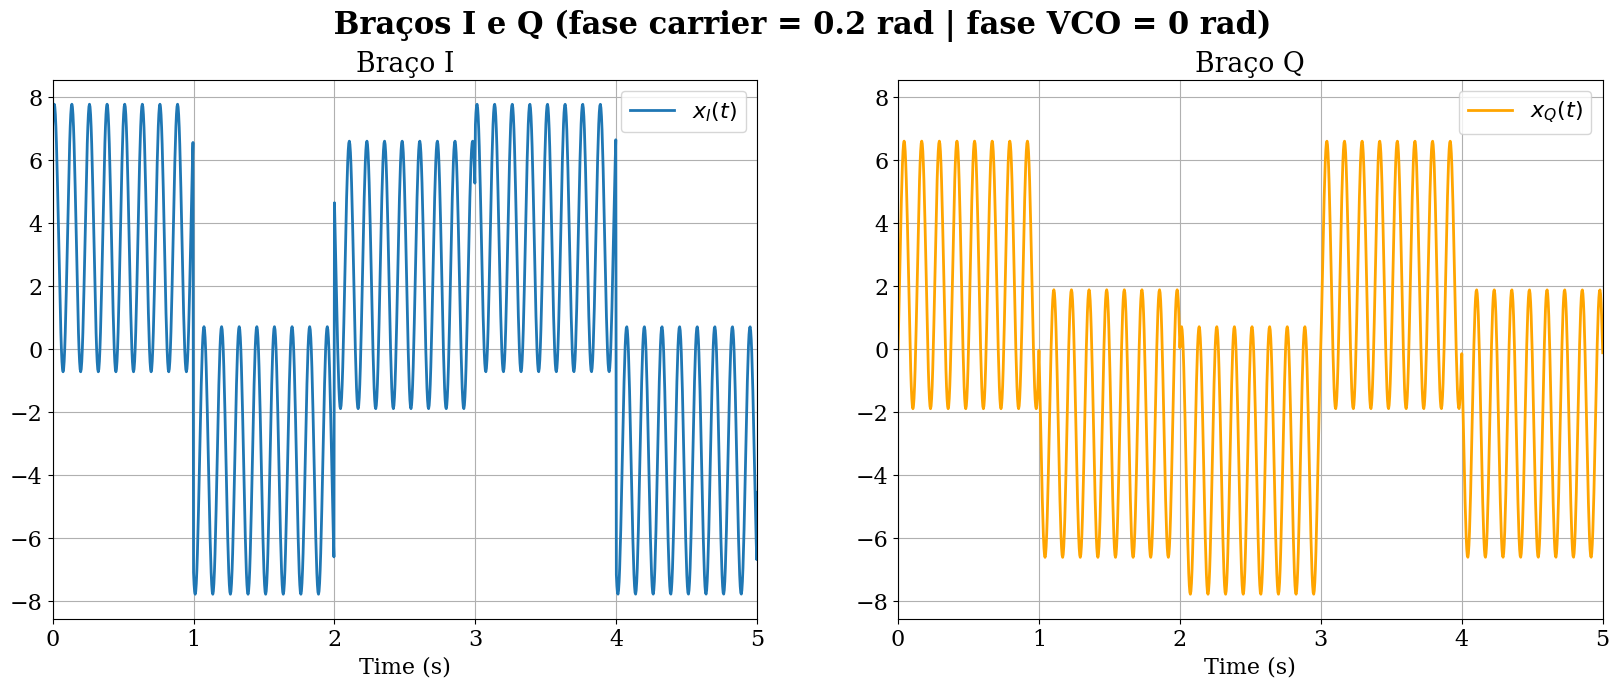

In [263]:
thetaCarrier = np.pi/16
thetaVCO = 0 

ri = BaseSigI*np.sqrt(2)*np.cos(2*np.pi*Fc*timearray + thetaCarrier)
rq = BaseSigQ*np.sqrt(2)*np.sin(2*np.pi*Fc*timearray + thetaCarrier)
VCOi = np.sqrt(2)*np.cos(2*np.pi*Fc*timearray + thetaVCO)
VCOq = np.sqrt(2)*np.sin(2*np.pi*Fc*timearray + thetaVCO)

xi = (ri+rq)*VCOi
xq = (ri+rq)*VCOq

figure, ax = plt.subplots(1,2,figsize=(20,7))
plt.rc('font',**font)
figure.suptitle(f' Braços I e Q (fase carrier = {np.round(thetaCarrier,2)} rad | fase VCO = {np.round(thetaVCO,2)} rad) ',fontsize=22, weight='bold')

ax[0].plot(timearray,xi,label='$x_I(t)$',linewidth=2)
ax[0].set_title('Braço I')
ax[0].set_xlabel('Time (s)')
ax[0].set_xlim(0,5)
ax[0].legend()
ax[0].grid()

ax[1].plot(timearray,xq,label='$x_Q(t)$',linewidth=2,color='orange')
ax[1].set_title('Braço Q')
ax[1].set_xlabel('Time (s)')
ax[1].set_xlim(0,5)
ax[1].legend()
ax[1].grid()

Tanto $x_I(t)$ quanto $x_Q(t)$ devem passar por um filtro passa-baixa para a eliminação das componentes de frequência $2F_c$, gerando $z_I(t)$ e $z_Q(t)$. Dessa forma, sobram-se apenas as partes da banda base:

$$\begin{cases} z_I(t) ~~=~~ v_I(t) \cdot cos(\theta - \widehat{\theta}) + v_Q(t) \cdot sin(\theta - \widehat{\theta}) \\ z_Q(t) ~~=~~ -v_I(t) \cdot sin(\theta - \widehat{\theta}) + v_Q(t) \cdot cos(\theta - \widehat{\theta}) \end{cases}$$

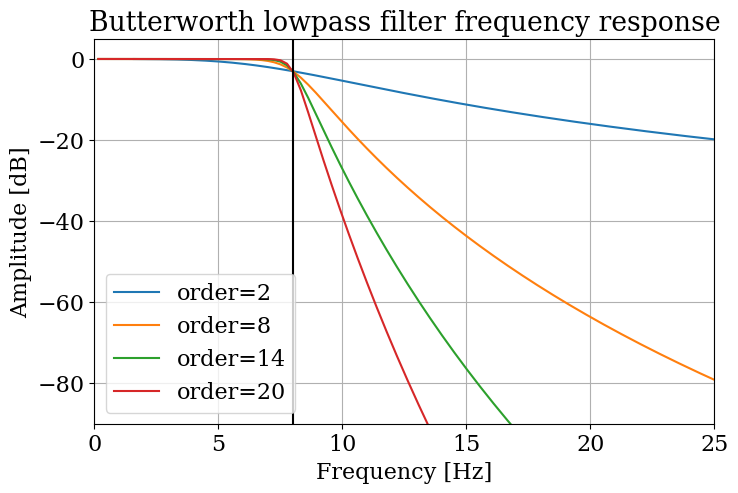

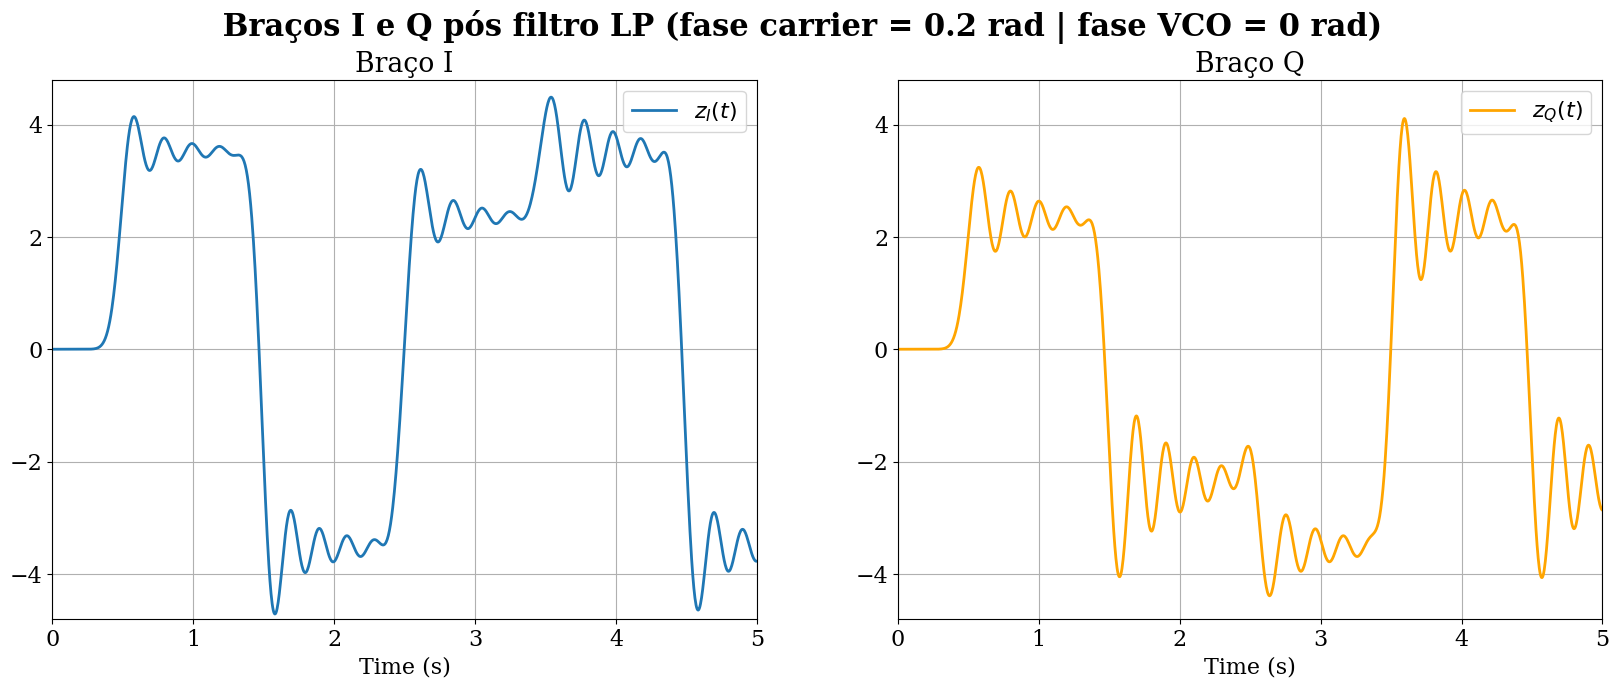

In [264]:
OrderArray = [2,8,14,20]
bArray = np.zeros((len(OrderArray),1))
aArray = np.zeros((len(OrderArray),max(OrderArray)+1))
wArray = np.zeros((len(OrderArray),200))
hArray = np.zeros((len(OrderArray),200),dtype=complex)

plt.figure(figsize=(8,5))
for order in range(len(OrderArray)):
    bArray[order,:], aArray[order,:OrderArray[order]+1] = signal.butter(OrderArray[order], 2*2*np.pi*Fc, 'low', analog=True)
    wArray[order,:], hArray[order,:] = signal.freqs(bArray[order,:], aArray[order,:OrderArray[order]+1])
    plt.plot(wArray[order,:]/(2*np.pi), 20 * np.log10(abs(hArray[order,:])),label=f'order={OrderArray[order]}')
plt.title('Butterworth lowpass filter frequency response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.xlim(0,25)
plt.ylim(-90,5)
plt.grid(which='both', axis='both')
plt.axvline(2*Fc, color='black') # cutoff frequency
plt.legend()

fs = SymbRate*M
w = 1.3*Fc / (fs/2)
LPfilter = signal.butter(24, w, 'low', output='sos')
zi = signal.sosfilt(LPfilter,xi)
zq = signal.sosfilt(LPfilter,xq)

figure, ax = plt.subplots(1,2,figsize=(20,7))
plt.rc('font',**font)
figure.suptitle(f' Braços I e Q pós filtro LP (fase carrier = {np.round(thetaCarrier,2)} rad | fase VCO = {np.round(thetaVCO,2)} rad) ',fontsize=22, weight='bold')

ax[0].plot(timearray,zi,label='$z_I(t)$',linewidth=2)
ax[0].set_title('Braço I')
ax[0].set_xlabel('Time (s)')
ax[0].set_xlim(0,5)
ax[0].set_ylim(1.6*ConstI[1],1.6*ConstI[0])
ax[0].legend()
ax[0].grid()

ax[1].plot(timearray,zq,label='$z_Q(t)$',linewidth=2,color='orange')
ax[1].set_title('Braço Q')
ax[1].set_xlabel('Time (s)')
ax[1].set_xlim(0,5)
ax[1].set_ylim(1.6*ConstQ[1],1.6*ConstQ[0])
ax[1].legend()
ax[1].grid()

Para reduzir o efeito da interferência entre símbolos e da escolha da janela retangular, aplica-se uma função **sign**, considerando que $\theta - \widehat{\theta}$ seja pequeno o suficiente (de tal forma que $cos(\theta - \widehat{\theta}) \approx 1$ e $sin(\theta - \widehat{\theta}) \approx 0$): $$sign\{z_I(t)\}=\widehat{a}_I[m] ~~~~~~~~,~~~~~~~~~sign\{z_Q(t)\}=\widehat{a}_Q[m]$$

<>:19: SyntaxWarning: invalid escape sequence '\w'
<>:27: SyntaxWarning: invalid escape sequence '\w'
<>:19: SyntaxWarning: invalid escape sequence '\w'
<>:27: SyntaxWarning: invalid escape sequence '\w'
C:\Users\caior\AppData\Local\Temp\ipykernel_14484\2434340237.py:19: SyntaxWarning: invalid escape sequence '\w'
  ax[0].plot(timearray,ai,label='$\widehat{a}_I[m]$',linewidth=2)
C:\Users\caior\AppData\Local\Temp\ipykernel_14484\2434340237.py:27: SyntaxWarning: invalid escape sequence '\w'
  ax[1].plot(timearray,aq,label='$\widehat{a}_Q[m]$',linewidth=2,color='orange')


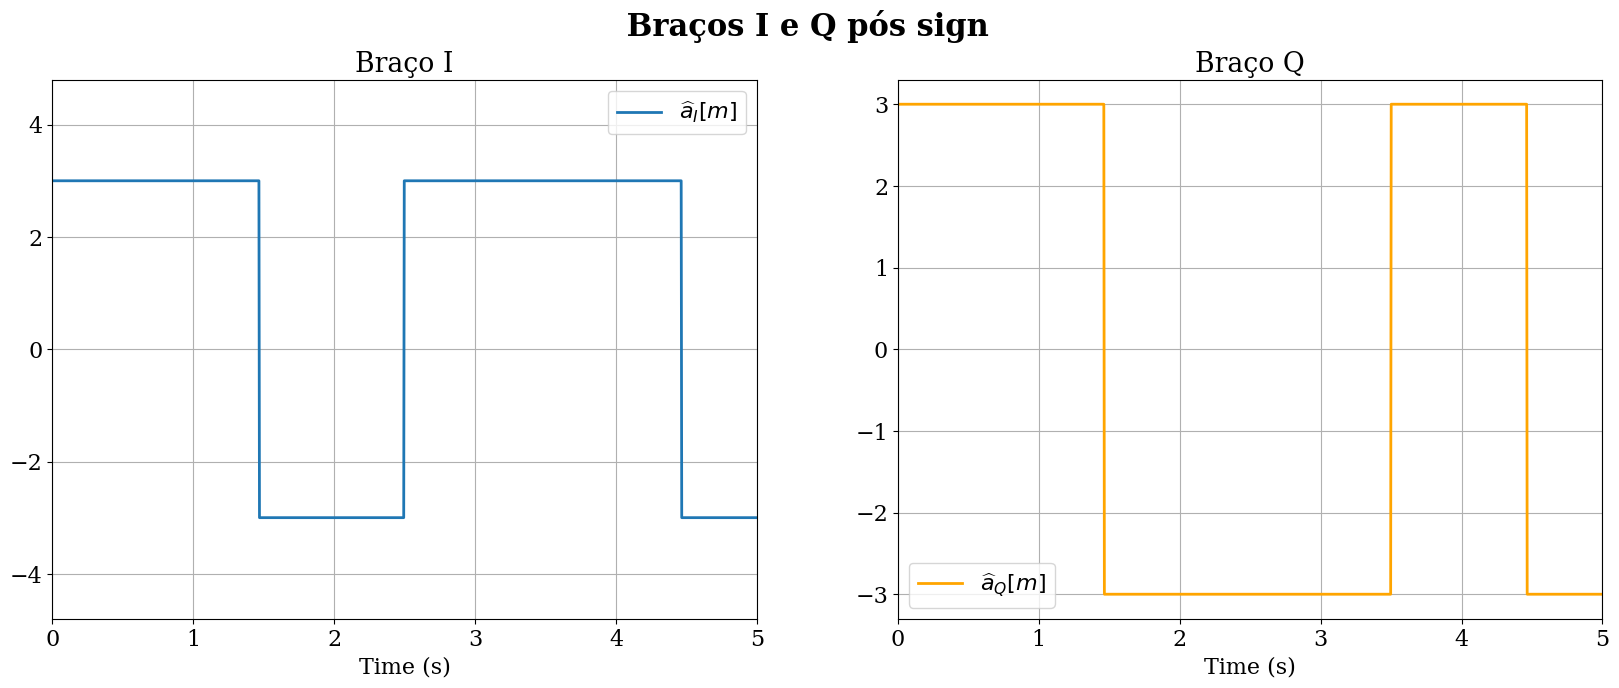

In [265]:
ai = np.zeros((len(zi)))
aq = np.zeros((len(zi)))

for i in range(len(zi)):
    if(zi[i] < 0):
        ai[i] =  ConstI[1]
    else:
        ai[i] = ConstI[0]

    if(zq[i] < 0):
        aq[i] =  ConstQ[1]
    else:
        aq[i] = ConstQ[0]

figure, ax = plt.subplots(1,2,figsize=(20,7))
plt.rc('font',**font)
figure.suptitle(f' Braços I e Q pós sign',fontsize=22, weight='bold')

ax[0].plot(timearray,ai,label='$\widehat{a}_I[m]$',linewidth=2)
ax[0].set_title('Braço I')
ax[0].set_xlabel('Time (s)')
ax[0].set_xlim(0,5)
ax[0].set_ylim(1.6*ConstI[1],1.6*ConstI[0])
ax[0].legend()
ax[0].grid()

ax[1].plot(timearray,aq,label='$\widehat{a}_Q[m]$',linewidth=2,color='orange')
ax[1].set_title('Braço Q')
ax[1].set_xlabel('Time (s)')
ax[1].set_xlim(0,5)
ax[0].set_ylim(1.6*ConstQ[1],1.6*ConstQ[0])
ax[1].legend()
ax[1].grid()

por fim, a função erro é dada:
$$e_D(t)=sign\{z_Q(t)\}z_I(t) - sign\{z_I(t)\}z_Q(t) = \widehat{a}_Q[m]z_I(t) - \widehat{a}_I[m]z_Q(t)$$

$$\text{ou, assumindo filtragem ideal:}$$

$$e_D(t) = [\widehat{a}_Q[m]v_I(t)-\widehat{a}_I[m]v_Q(t)]\cdot cos(\theta - \widehat{\theta}) + [\widehat{a}_Q[m]v_Q(t)+\widehat{a}_I[m]v_I(t)]\cdot sin(\theta - \widehat{\theta})$$

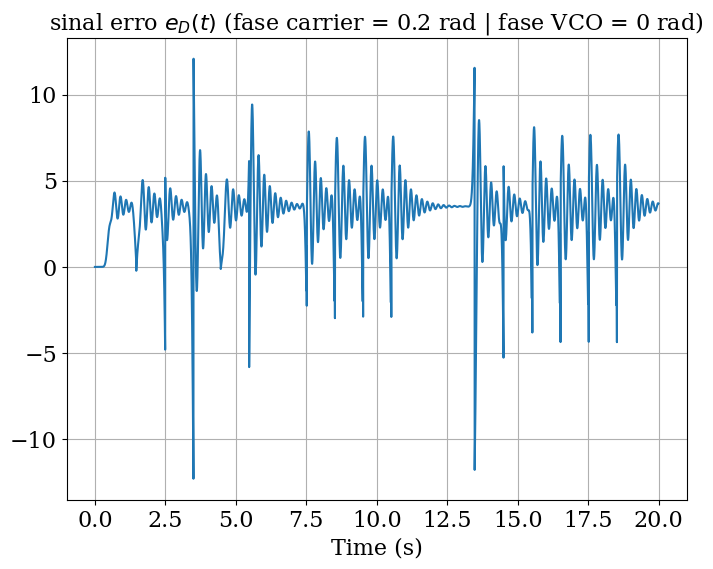

In [266]:
ed = aq*zi - ai*zq
plt.figure(figsize=(8,6))
plt.plot(timearray,ed)
plt.title(f'sinal erro $e_D(t)$ (fase carrier = {np.round(thetaCarrier,2)} rad | fase VCO = {np.round(thetaVCO,2)} rad)',fontsize=16)
plt.xlabel('Time (s)')
plt.grid()

por fim, aplica-se um filtro passa baixa para resgatar o sinal de baixa frequência, para assim ser entregue novamente ao VCO

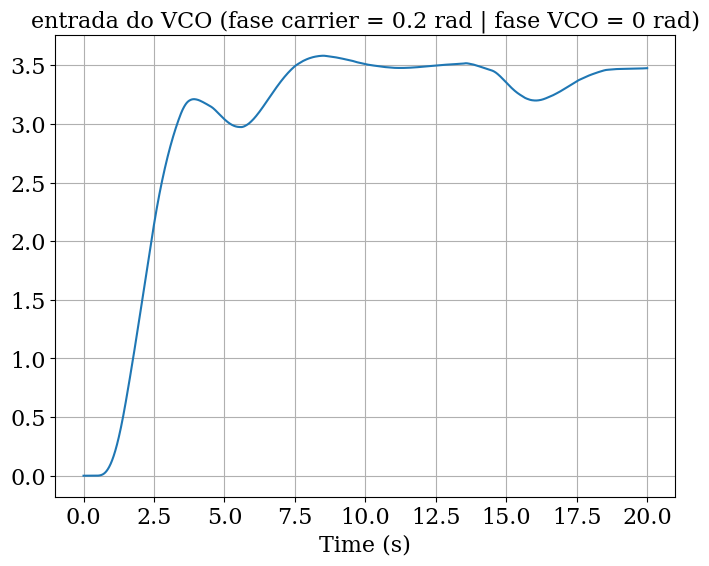

In [267]:
fs = SymbRate*M
w = (Fc/20) / (fs/2)
LPfilter = signal.butter(3, w, 'low', output='sos')
VCOin = signal.sosfilt(LPfilter,ed)

plt.figure(figsize=(8,6))
plt.plot(timearray,VCOin)
plt.title(f'entrada do VCO (fase carrier = {np.round(thetaCarrier,2)} rad | fase VCO = {np.round(thetaVCO,2)} rad)',fontsize=16)
plt.xlabel('Time (s)')
plt.grid()

# Comparando várias fases

<>:63: SyntaxWarning: invalid escape sequence '\D'
<>:63: SyntaxWarning: invalid escape sequence '\D'
C:\Users\caior\AppData\Local\Temp\ipykernel_14484\3010169259.py:63: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(timearray,VCOin,label=f'$\Delta phase$={np.round(thetaArray[c],2)}rad')


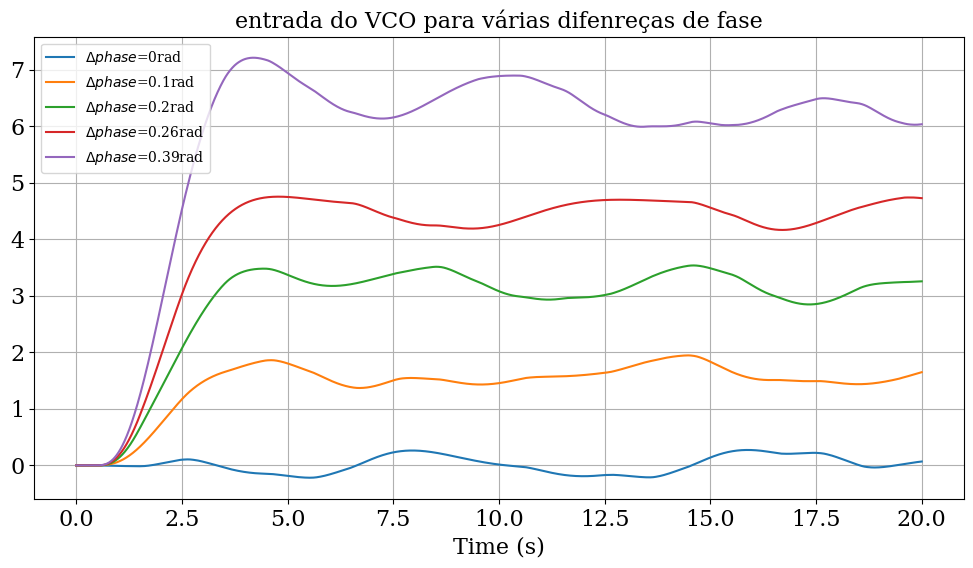

In [268]:
thetaArray = [0,np.pi/32,np.pi/16,np.pi/12,np.pi/8]

PtsNum = 20 # Number of points
M = 256 # Upsample by M
ConstI = [3,-3] # I Constellation
ConstQ = [3,-3] # Q Constellation
Fc = 4      # Carrier frequency (Hz)
SymbRate = 1 # Symbol Transmission Rate (symb/s)

plt.figure(figsize=(12,6))

for c in range(len(thetaArray)):
    thetaCarrier = thetaArray[c]
    thetaVCO = 0 

    window = np.ones(M) # Janela retangular

    sig = np.zeros(PtsNum*M)
    sig[::M] = np.random.choice(ConstI,int(PtsNum))
    BaseSigI = np.convolve(window,sig)[:PtsNum*M]

    sig = np.zeros(PtsNum*M)
    sig[::M] = np.random.choice(ConstQ,int(PtsNum))
    BaseSigQ = np.convolve(window,sig)[:PtsNum*M]

    timearray = np.linspace(0,PtsNum/SymbRate,PtsNum*M)

    ri = BaseSigI*np.sqrt(2)*np.cos(2*np.pi*Fc*timearray + thetaCarrier)
    rq = BaseSigQ*np.sqrt(2)*np.sin(2*np.pi*Fc*timearray + thetaCarrier)
    VCOi = np.sqrt(2)*np.cos(2*np.pi*Fc*timearray + thetaVCO)
    VCOq = np.sqrt(2)*np.sin(2*np.pi*Fc*timearray + thetaVCO)

    xi = (ri+rq)*VCOi
    xq = (ri+rq)*VCOq

    fs = SymbRate*M
    w = 1.3*Fc / (fs/2)
    LPfilter = signal.butter(24, w, 'low', output='sos')
    zi = signal.sosfilt(LPfilter,xi)
    zq = signal.sosfilt(LPfilter,xq)

    ai = np.zeros((len(zi)))
    aq = np.zeros((len(zi)))

    for i in range(len(zi)):
        if(zi[i] < 0):
            ai[i] =  ConstI[1]
        else:
            ai[i] = ConstI[0]

        if(zq[i] < 0):
            aq[i] =  ConstQ[1]
        else:
            aq[i] = ConstQ[0]

    ed = aq*zi - ai*zq

    fs = SymbRate*M
    w = (Fc/20) / (fs/2)
    LPfilter = signal.butter(3, w, 'low', output='sos')
    VCOin = signal.sosfilt(LPfilter,ed)

    plt.plot(timearray,VCOin,label=f'$\Delta phase$={np.round(thetaArray[c],2)}rad')

plt.title(f'entrada do VCO para várias difenreças de fase',fontsize=16)
plt.xlabel('Time (s)')
plt.legend(fontsize=10)
plt.grid()